# Gender Classification
Train a simple gender classification model.
The model will guess either male or female by the given 88 GeMAPS features.

In [1]:
# Imports
# Python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier

import tensorflow as tf
from keras import Sequential, layers
import shap

import IPython.display as ipd
import seaborn as sns

# Custom package
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / "src"))
from age_by_voice.dataset_prep.dataset_preparator import Dataset_Perparator

2025-04-19 22:26:12.110550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-19 22:26:12.120932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-19 22:26:12.124203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 22:26:12.131606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/chr1s/.conda/envs/age_by_voic

In [2]:
rand_state = 420

In [3]:
voices_path = "/home/chr1s/Dokumente/github/Programming/Python/Age_by_Voice/data/csv_saves/opensmile/save_voices_5000.csv"
features_path = "/home/chr1s/Dokumente/github/Programming/Python/Age_by_Voice/data/csv_saves/opensmile/save_features_5000.csv"
audio_path = "/home/chr1s/Downloads/cv-corpus-21.0-2025-03-14/en/clips/"

In [10]:
data_prep = Dataset_Perparator(voices_path, features_path) # , normalize=True
data_prep.check_balance(feature="gender")

In [11]:
# play random audio file
file = data_prep.voices.audio_file_name.sample(1).values[0]
file_path = os.path.join(audio_path, file)

ipd.Audio(file_path)  # Play the audio file

In [12]:
# Analyze the data
data = data_prep.features.copy()
data = data.drop(columns=["clip_id"])
data["gender"] = data_prep.voices["voice_gender"].map({'m': 1, 'f': 0})

<Axes: >

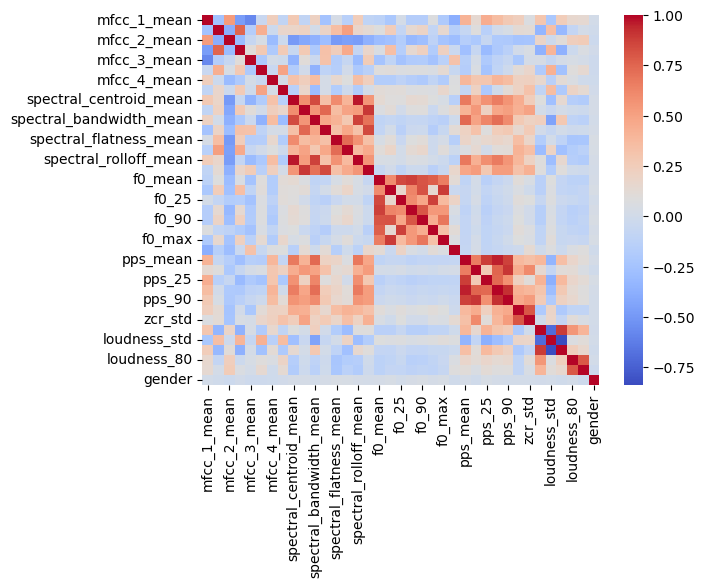

In [16]:
sns.heatmap(data.corr(), fmt=".2f", cmap="coolwarm")

In [14]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706 entries, 0 to 1705
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mfcc_1_mean              1706 non-null   float64
 1   mfcc_1_std               1706 non-null   float64
 2   mfcc_2_mean              1706 non-null   float64
 3   mfcc_2_std               1706 non-null   float64
 4   mfcc_3_mean              1706 non-null   float64
 5   mfcc_3_std               1706 non-null   float64
 6   mfcc_4_mean              1706 non-null   float64
 7   mfcc_4_std               1706 non-null   float64
 8   spectral_centroid_mean   1706 non-null   float64
 9   spectral_centroid_std    1706 non-null   float64
 10  spectral_bandwidth_mean  1706 non-null   float64
 11  spectral_bandwidth_std   1706 non-null   float64
 12  spectral_flatness_mean   1706 non-null   float64
 13  spectral_flatness_std    1706 non-null   float64
 14  spectral_rolloff_mean   

,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,spectral_centroid_mean,spectral_centroid_std,...,pps_80,pps_90,zcr_mean,zcr_std,loudness_mean,loudness_std,loudness_25,loudness_80,loudness_90,gender
count,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,...,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000,1706.000000
mean,-41.307556,4.216122,8.583542,2.641752,0.372260,1.746749,1.054914,1.613959,1662.195640,873.788182,...,2579.849551,3646.441970,0.083788,0.069585,-26.790885,18.688813,-43.416888,-8.931958,-5.470738,0.500000
std,3.378148,1.282448,1.650858,0.861990,1.402115,0.478369,1.022796,0.466593,647.299708,373.112327,...,1236.208359,1632.406098,0.038559,0.031426,8.191139,6.012934,15.335543,5.706193,3.249658,0.500147
min,-52.413217,1.393552,-2.312816,0.539854,-9.764950,0.275743,-2.954830,0.218647,559.617678,159.147175,...,361.111111,372.222222,0.009208,0.008260,-66.130931,1.536662,-80.000000,-62.946333,-51.351006,0.000000
25%,-43.274670,3.331192,7.567678,2.032872,-0.467777,1.459272,0.395622,1.307354,1219.499936,609.893112,...,1700.833333,2427.500000,0.056704,0.047164,-31.616200,14.298546,-53.333333,-9.992686,-6.610566,0.000000
50%,-41.369284,4.054480,8.648676,2.530899,0.474035,1.762433,1.061012,1.627144,1529.510491,817.194917,...,2325.555556,3427.222222,0.076532,0.065265,-25.947506,18.079880,-41.985458,-7.849846,-4.864523,0.500000
75%,-39.524234,4.974993,9.698937,3.115795,1.263011,2.033386,1.689505,1.897959,1942.201122,1086.460788,...,3210.833333,4611.944444,0.105420,0.088224,-21.079027,22.720668,-31.955956,-6.075466,-3.624058,1.000000
max,-17.137632,11.039328,14.824260,6.045439,4.756784,3.725877,6.382484,3.182913,6401.119988,3801.497251,...,10443.333333,10871.111111,0.309538,0.212692,-2.198460,34.809627,-2.466339,-0.676227,-0.359907,1.000000


<Axes: xlabel='voice_gender'>

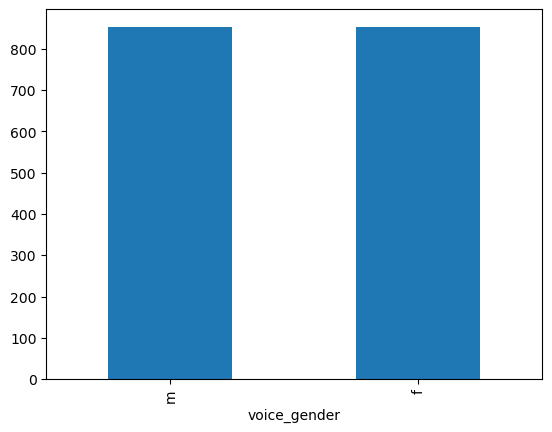

In [15]:
# plot the gender count
data_prep.voices.voice_gender.value_counts().plot(kind='bar')

In [ ]:
X = data.drop(columns=["gender"])
y = data["gender"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand_state)

In [ ]:
X_train.shape

In [ ]:
tree = DecisionTreeClassifier(max_depth=19, random_state=rand_state)

In [ ]:
tree.fit(X_train, y_train)

In [ ]:
# Model Score
print(f"Train score: {tree.score(X_train, y_train)}")
print(f"Test score: {tree.score(X_test, y_test)}")

In [ ]:
# train confusion matrix
y_train_pred = tree.predict(X_train)
confusion_matrix(y_train, y_train_pred) / y_train.shape[0]

In [ ]:
# test confusion matrix
y_test_pred = tree.predict(X_test)
confusion_matrix(y_test, y_test_pred) / y_test.shape[0]

In [ ]:
fig = plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, class_names=["f", "m"], filled=True)

plt.show()

In [ ]:
logreg = LogisticRegression(random_state=rand_state)
logreg.fit(X_train, y_train)

In [ ]:
# train confusion matrix
y_train_pred = logreg.predict(X_train)
confusion_matrix(y_train, y_train_pred) / y_train.shape[0]

In [ ]:
# test confusion matrix
y_test_pred = logreg.predict(X_test)
confusion_matrix(y_test, y_test_pred) / y_test.shape[0]

In [ ]:
# Model Score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

In [ ]:
X = data.drop(columns=["gender"])
y = pd.DataFrame()
y['m'] = data['gender']
y['f'] = 1 - data['gender'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand_state)

In [ ]:
# DNN Model
model = Sequential([
    layers.Input(shape=(36,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=50, validation_split=0.2)